## Steam data cleaning for linear regression:
### This is a more condensed version of the data cleaning process that doesn't walk through the exploration process. If you'd like to see the data explored a bit more and know why these cleaning steps were necessary, the other document is far more verbose.

In [72]:
import pandas as pd
import seaborn as sns
import patsy
import statsmodels.api as sm
from sklearn.feature_extraction.text import CountVectorizer as cv
import fuzzywuzzy
from fuzzywuzzy import process
import numpy as np

In [73]:
steam_games_df = pd.read_json('steam_games_dicts_selenium.json')

In [74]:
steamDB_users_df = pd.read_csv('steam_users_table.csv', thousands=',')

In [75]:
steamDB_users_df['AppID'] = steamDB_users_df['AppID'].astype('int64')

### Loading the data from pickle:

In [76]:
import pickle

# Getting back the objects:
with open('objs_steam_data.pkl', 'rb') as f:
    y, X, steam_combined, steamDB_users_df_fuzzy_final, steamDB_users_df_fuzzy, steamDB_users_df, steam_combined_expanded, steam_combined_fuzzy = pickle.load(f)
f.close()

### Combining all cleaning of steam_games_df:

In [77]:
steam_games_df.fillna(value=0, inplace=True) 

# removing two symbols present in one frame that appear absent from the other
steam_games_df['app_name'].replace(regex=True,inplace=True,to_replace=r'®',value=r'')
steam_games_df['app_name'].replace(regex=True,inplace=True,to_replace=r'™',value=r'')

# removing these two symbols gives us 6478 instead of 6428 rows after merging

### Fuzzy matching to recover additional games:

In [78]:
missing_names = set(steamDB_users_df['Name']).difference(set(steam_games_df['app_name']))
len(missing_names)

2040

In [79]:
steamDB_users_df_fuzzy.head()

,AppID,Name,Current,24h Peak,All-Time Peak,steam_match_name,fuzzy_score
0,753,Steam,9469112,14752493,18537490,A Study in Steampunk: Choice by Gaslight,90
1,578080,PLAYERUNKNOWN'S BATTLEGROUNDS,282809,1992584,3257248,PLAYERUNKNOWN'S BATTLEGROUNDS,100
2,570,Dota 2,226441,621653,1295114,Dota 2,100
3,730,Counter-Strike: Global Offensive,172999,421633,854801,Counter-Strike: Global Offensive,100
4,359550,Tom Clancy's Rainbow Six Siege,40794,99486,178953,Tom Clancy's Rainbow Six Siege,100


In [80]:
steamDB_users_df_fuzzy_final = steamDB_users_df_fuzzy.loc[steamDB_users_df_fuzzy.fuzzy_score >93].copy()
steamDB_users_df_fuzzy_final.head()

,AppID,Name,Current,24h Peak,All-Time Peak,steam_match_name,fuzzy_score
1,578080,PLAYERUNKNOWN'S BATTLEGROUNDS,282809,1992584,3257248,PLAYERUNKNOWN'S BATTLEGROUNDS,100
2,570,Dota 2,226441,621653,1295114,Dota 2,100
3,730,Counter-Strike: Global Offensive,172999,421633,854801,Counter-Strike: Global Offensive,100
4,359550,Tom Clancy's Rainbow Six Siege,40794,99486,178953,Tom Clancy's Rainbow Six Siege,100
5,440,Team Fortress 2,38309,45415,120436,Team Fortress 2,100


In [81]:
steamDB_users_df_fuzzy_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7277 entries, 1 to 8502
Data columns (total 7 columns):
AppID               7277 non-null int64
Name                7277 non-null object
Current             7277 non-null int64
24h Peak            7277 non-null int64
All-Time Peak       7277 non-null int64
steam_match_name    7277 non-null object
fuzzy_score         7277 non-null int64
dtypes: int64(5), object(2)
memory usage: 454.8+ KB


In [82]:
steam_combined_fuzzy = pd.merge(steam_games_df, steamDB_users_df_fuzzy_final, left_on='app_name', right_on='steam_match_name', how='inner', sort=False)

In [83]:
# check number of recovered entries
len(steamDB_users_df_fuzzy_final)-len(steam_combined)

799

In [84]:
steam_combined_fuzzy.head()

,Developer,Genre,Publisher,Release Date,Title,app_id,app_name,discount_price,early_access,esrb,...,steam_Achievement_n,tags,url,AppID,Name,Current,24h Peak,All-Time Peak,steam_match_name,fuzzy_score
0,[WTFOMGames],"[Action, Adventure, Casual, Indie]",[WTFOMGames],"Mar 1, 2016",! That Bastard Is Trying To Steal Our Gold !,449940,! That Bastard Is Trying To Steal Our Gold !,3.99,False,,...,0,"[Action, Indie, Casual, Adventure, Memes, Psyc...",https://store.steampowered.com/app/449940/_Tha...,449940,! That Bastard Is Trying To Steal Our Gold !,1,27,1951,! That Bastard Is Trying To Steal Our Gold !,100
1,[Beatshapers],"[Action, Indie]","[8Floor, Beatshapers]","Aug 10, 2016",#KILLALLZOMBIES,303720,#KILLALLZOMBIES,4.99,False,t,...,10,"[Action, Indie, Zombies, Twin Stick Shooter]",https://store.steampowered.com/app/303720/KILL...,303720,#killallzombies,2,163,3879,#KILLALLZOMBIES,100
2,[Paleno Games],"[Casual, Indie]",[Paleno Games],"May 5, 2017",#monstercakes,614910,#monstercakes,0.99,False,,...,18,"[Casual, Indie, Puzzle, Match 3]",https://store.steampowered.com/app/614910/mons...,614910,#monstercakes,57,70,189,#monstercakes,100
3,[Eko],"[Adventure, Indie]",[Eko],"Mar 14, 2018",#WarGames,779420,#WarGames,2.99,False,,...,55,"[Adventure, Indie, FMV]",https://store.steampowered.com/app/779420/WarG...,779420,#WarGames,2,5,36,#WarGames,100
4,[BeHappy Studios],"[Action, Casual, Indie]",[Back To Basics Gaming],"Jul 28, 2016",$1 Ride,508290,$1 Ride,0.98,False,,...,0,"[Casual, Indie, Action]",https://store.steampowered.com/app/508290/1_Ride/,508290,$1 Ride,1,4,2002,$1 Ride,100


In [85]:
steam_combined_fuzzy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7295 entries, 0 to 7294
Data columns (total 29 columns):
Developer               7295 non-null object
Genre                   7295 non-null object
Publisher               7295 non-null object
Release Date            7295 non-null object
Title                   7295 non-null object
app_id                  7295 non-null object
app_name                7295 non-null object
discount_price          7295 non-null object
early_access            7295 non-null bool
esrb                    7295 non-null object
mature_reasons          7295 non-null object
metascore               7295 non-null object
overall_rev_pos_perc    7295 non-null int64
overall_reviews_n       7295 non-null int64
price                   7295 non-null float64
recent_rev_pos_perc     7295 non-null int64
recent_reviews_n        7295 non-null object
reviews_url             7295 non-null object
specs                   7295 non-null object
steam_Achievement_n     7295 non-null int6

### Combining all the cleaning steps for steam_combined_fuzzy:

In [86]:
# Combining all cleaning of steam_combined:

# changing spaces in column names to underscores to make dealing with them easier:
steam_combined_fuzzy.rename(columns={'All-Time Peak': 'All_Time_Peak_concurrent_users', 'Release Date': 'Release_Date'}, inplace=True)

# temporarily dealing with missing esrb ratings by filling empty values with nr for "not rated":
steam_combined_fuzzy['esrb'].replace('', 'nr', inplace= True)

# replacing string values in discount_price as 0.00 and making it type float:
steam_combined_fuzzy['discount_price'] = steam_combined_fuzzy.discount_price.replace('Free To Play',0.00).replace('Free to Play',0.00).replace('Free',0.00).astype(float)

# Making the metascore numeric:
steam_combined_fuzzy.metascore = steam_combined_fuzzy.metascore.replace('NA','NaN').astype('float')

# Making the metascore numeric:
steam_combined_fuzzy.recent_reviews_n = steam_combined_fuzzy.recent_reviews_n.str.replace(',','').astype(float)

### Expanding the feature columns that contain lists (tags, genre, etc):

In [87]:
def not_list_to_empty_list(row):
    if type(row) != list:
        row = []
    return row

In [88]:
def create_new_columns_as_counts_from_lists(old_df, colname):
    vect = cv()
    vect.fit(old_df[colname].str.join(' '))
    X = vect.transform(old_df[colname].str.join(' '))
    df_of_new_cols = pd.DataFrame(X.toarray(),columns=vect.get_feature_names())
    new_df = old_df.join(df_of_new_cols, rsuffix=colname).copy()
    return new_df
    """Makes a new dataframe expanding a column with lists into several columns with counts for each element"""

In [89]:
def expand_list_columns(df, colname):
    newcolname = colname+'_new'
    df[newcolname] = df[colname].apply(not_list_to_empty_list)
    df = create_new_columns_as_counts_from_lists(df,newcolname).copy()
    return df

In [90]:
steam_combined_expanded_fuzzy = expand_list_columns(steam_combined_fuzzy,'tags').copy()

In [91]:
steam_combined_expanded_fuzzy = expand_list_columns(steam_combined_expanded_fuzzy,'Genre').copy()

In [92]:
steam_combined_expanded_fuzzy = expand_list_columns(steam_combined_expanded_fuzzy,'Developer').copy()

In [93]:
steam_combined_expanded_fuzzy = expand_list_columns(steam_combined_expanded_fuzzy,'Publisher').copy()

In [94]:
steam_combined_expanded_fuzzy = expand_list_columns(steam_combined_expanded_fuzzy,'specs').copy()

In [95]:
steam_combined_expanded_fuzzy = expand_list_columns(steam_combined_expanded_fuzzy,'mature_reasons').copy()

### Making the intercept column and creating dummy variable columns for ESRB and Early access:

In [96]:
#steam_combined_expanded = create_new_columns_as_counts_from_lists(steam_combined_expanded,'esrb').copy()
y,X = patsy.dmatrices('All_Time_Peak_concurrent_users ~ esrb + early_access', data=steam_combined_expanded_fuzzy, return_type="dataframe")
#X.head()
for colname in X.columns:
    steam_combined_expanded_fuzzy[colname] = X[colname]

In [97]:
steam_combined_expanded_fuzzy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7295 entries, 0 to 7294
Columns: 9882 entries, Developer to early_access[T.True]
dtypes: bool(1), float64(11), int64(9849), object(21)
memory usage: 550.0+ MB


### Dropping the old list columns as well as miscellaneous other columns we don't want in there:

In [113]:
y = steam_combined_expanded_fuzzy['All_Time_Peak_concurrent_users']
X = steam_combined_expanded_fuzzy.drop(['fuzzy_score','steam_match_name','specs','specs_new','early_access','Title' , 'tags' , 'tags_new' , 'Genre' , 'Genre_new' , 'Developer' , 'Developer_new' , 'Publisher' , 'Publisher_new' , 'mature_reasons' , 'mature_reasons_new' , 'esrb' , 'app_id' , 'app_name' , 'url' , 'reviews_url' , 'AppID' , 'Name' , 'Current' , '24h Peak', 'All_Time_Peak_concurrent_users'], axis=1)
#X['intercept']=1 #This is now taken care off by the patsy step with esrb
#X.intercept.dtype

In [114]:
X.head()

,Release_Date,discount_price,metascore,overall_rev_pos_perc,overall_reviews_n,price,recent_rev_pos_perc,recent_reviews_n,steam_Achievement_n,1980s,...,violentmature_reasons_new,visit,withmature_reasons_new,Intercept,esrb[T.e],esrb[T.m],esrb[T.nr],esrb[T.r],esrb[T.t],early_access[T.True]
0,"Mar 1, 2016",3.99,0.0,46,15,3.99,0,NaN,0,0,...,0,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,"Aug 10, 2016",4.99,0.0,47,19,4.99,0,NaN,10,0,...,0,0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,"May 5, 2017",0.99,0.0,90,272,0.99,80,NaN,18,0,...,0,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,"Mar 14, 2018",2.99,0.0,66,54,2.99,0,NaN,55,0,...,0,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,"Jul 28, 2016",0.98,0.0,58,80,0.98,0,NaN,0,0,...,0,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


### Figuring out which columns still had offending non-numerical values:

In [115]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7295 entries, 0 to 7294
Columns: 9856 entries, Release_Date to early_access[T.True]
dtypes: float64(11), int64(9844), object(1)
memory usage: 548.6+ MB


In [116]:
X.select_dtypes(include='object').head()
# Release_Date and recent_reviews_n

,Release_Date
0,"Mar 1, 2016"
1,"Aug 10, 2016"
2,"May 5, 2017"
3,"Mar 14, 2018"
4,"Jul 28, 2016"


### Fixing columns with offending non-numerical values:

In [121]:
# Temporarily excluding release date
#X.Release_Date = pd.to_datetime(X.Release_Date, errors='coerce')

### Making appropriate dataframes for modeling by dropping inapppriate columns (X variables):

In [122]:
y = steam_combined_expanded_fuzzy['All_Time_Peak_concurrent_users']
X = steam_combined_expanded_fuzzy.drop(['Release_Date','fuzzy_score', 'steam_match_name','specs','specs_new','early_access','Title' , 'tags' , 'tags_new' , 'Genre' , 'Genre_new' , 'Developer' , 'Developer_new' , 'Publisher' , 'Publisher_new' , 'mature_reasons' , 'mature_reasons_new' , 'esrb' , 'app_id' , 'app_name' , 'url' , 'reviews_url' , 'AppID' , 'Name' , 'Current' , '24h Peak', 'All_Time_Peak_concurrent_users'], axis=1)
# X.drop(['fuzzy_score'], axis=1, inplace=True)
#X['intercept']=1 #This is now taken care of by the patsy step with esrb
#X.intercept.dtype

In [123]:
X.shape

(7295, 9855)

In [124]:
# Create your model
#model = sm.OLS(y,X)
model = sm.OLS(y,np.nan_to_num(X))
# Fit your model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     All_Time_Peak_concurrent_users   R-squared:                       0.903
Model:                                        OLS   Adj. R-squared:                  0.667
Method:                             Least Squares   F-statistic:                     3.826
Date:                            Sun, 27 May 2018   Prob (F-statistic):          7.60e-238
Time:                                    21:31:41   Log-Likelihood:                -79899.
No. Observations:                            7295   AIC:                         1.701e+05
Df Residuals:                                2124   BIC:                         2.058e+05
Df Model:                                    5170                                         
Covariance Type:                        nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           145.7478    229.339      0.636      0.525    -304.004     595.500
x2            33.2634     25.071      1.327      0.185     -15.902      82.429
x3           -11.6064     29.694     -0.391      0.696     -69.839      46.627
x4             0.2945      0.014     21.594      0.000       0.268       0.321
x5           -93.3285    225.088     -0.415      0.678    -534.745     348.088
x6           -23.1617     24.711     -0.937      0.349     -71.622      25.299
x7             0.5352      1.413      0.379      0.705      -2.236       3.306
x8            35.3702     39.890      0.887      0.375     -42.858     113.599
x9          1.132e+04   8111.165      1.396      0.163   -4584.519    2.72e+04
x10         2486.3299   5313.866      0.468      0.640   -7934.594    1.29e+04
x11          195.3326   2717.645      0.072      0.943   -5134.190    5524.855
x12        -2668.0742   9113.655     -0.293      0.770   -2.05e+04    1.52e+04
x13        -7566.1917   7811.792     -0.969      0.333   -2.29e+04    7753.369
x14         -719.7431   6486.979     -0.111      0.912   -1.34e+04     1.2e+04
x15         2180.3475   7122.258      0.306      0.760   -1.18e+04    1.61e+04
x16         1.208e+04   1.76e+04      0.687      0.492   -2.24e+04    4.66e+04
x17        -3055.5141   1.46e+04     -0.210      0.834   -3.16e+04    2.55e+04
x18         -821.6914    839.288     -0.979      0.328   -2467.603     824.220
x19         1630.9498   2313.226      0.705      0.481   -2905.475    6167.375
x20        -3412.3039   2273.212     -1.501      0.133   -7870.257    1045.650
x21        -1369.5321   1.22e+04     -0.112      0.911   -2.54e+04    2.26e+04
x22          252.0538   5226.294      0.048      0.962   -9997.134    1.05e+04
x23         -204.9472   4533.015     -0.045      0.964   -9094.558    8684.664
x24         4073.3944   9000.069      0.453      0.651   -1.36e+04    2.17e+04
x25        -1940.4958   1554.503     -1.248      0.212   -4989.002    1108.010
x26        -3643.3447   1.23e+04     -0.296      0.767   -2.78e+04    2.05e+04
x27         1507.0596   3698.495      0.407      0.684   -5745.990    8760.109
x28          185.4706   2474.727      0.075      0.940   -4667.671    5038.612
x29         3261.9952   3812.396      0.856      0.392   -4214.424    1.07e+04
x30        -3357.3421   8692.369     -0.386      0.699   -2.04e+04    1.37e+04
x31         1.319e+04   1.37e+04      0.960      0.337   -1.38e+04    4.01e+04
x32        -8429.1665   1.32e+04     -0.639      0.523   -3.43e+04    1.74e+04
x33         1.999e+04   1.13e+04      1.774      0.076   -2110.444    4.21e+04
x34         2.712e+04    1.6e+04      1.692      0.091   -4310.860    5.85e+04
x35           39.5651   2268

In [130]:
# from sklearn import model_selection, pipeline, preprocessing, linear_model
# from sklearn.metrics import mean_squared_error
# from sklearn.linear_model import Lasso
# import numpy as np

In [131]:
# X = np.nan_to_num(X)
print(y.shape, X.shape)
y.dtype

(7295,) (7295, 9855)


dtype('int64')

In [132]:
# y = y.astype(float)
# X = X.astype(float)
#y = y.reset_index().as_matrix().astype(np.float)
#X = X.reset_index().as_matrix().astype(np.float)

In [133]:
X.head()

,discount_price,metascore,overall_rev_pos_perc,overall_reviews_n,price,recent_rev_pos_perc,recent_reviews_n,steam_Achievement_n,1980s,1990,...,violentmature_reasons_new,visit,withmature_reasons_new,Intercept,esrb[T.e],esrb[T.m],esrb[T.nr],esrb[T.r],esrb[T.t],early_access[T.True]
0,3.99,0.0,46,15,3.99,0,NaN,0,0,0,...,0,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,4.99,0.0,47,19,4.99,0,NaN,10,0,0,...,0,0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.99,0.0,90,272,0.99,80,NaN,18,0,0,...,0,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2.99,0.0,66,54,2.99,0,NaN,55,0,0,...,0,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.98,0.0,58,80,0.98,0,NaN,0,0,0,...,0,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [134]:
# Saving X and y as pickles:

with open('X.pkl', 'wb') as f:
    pickle.dump(X, f)
f.close()

with open('y.pkl', 'wb') as f:
    pickle.dump(y, f)
f.close()

with open('steam_combined_expanded_fuzzy.pkl', 'wb') as f:
    pickle.dump(steam_combined_expanded_fuzzy, f)
f.close()

notes on steps from Julia:

test-train split

score on x_train, y_train and x_test, y_test

standardize

lasso

plot residuals

seaborn jointplot for my strongest x

put my lasso-determined variables back into statsmodels

In [47]:
elastic_pipe = pipeline.Pipeline([
    ("std", preprocessing.StandardScaler()),
    ("elastic", linear_model.ElasticNet(alpha=1.0, l1_ratio=0.5))
])

In [48]:
elastic_pipe.fit(np.nan_to_num(X), y)
#linear_model.ElasticNet(alpha=1.0, l1_ratio=0.5).fit(X.astype(float), y)

Pipeline(memory=None,
     steps=[('std', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elastic', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))])

In [50]:
elastic_pipe.score(np.nan_to_num(X), y)

0.8469663269691714

In [52]:
coefs = elastic_pipe.named_steps["elastic"].coef_
coefs

array([ 494.65309165,  750.3583255 , -190.37428903, ...,  136.76775283,
         -1.72511321, -106.89049196])

In [511]:
y_pred = elastic_pipe.predict(np.nan_to_num(X))

In [512]:
sns.plot(y,X)

AttributeError: module 'seaborn' has no attribute 'plot'

In [51]:
coefs = elastic_pipe.named_steps["elastic"].coef_
coefs

array([ 494.65309165,  750.3583255 , -190.37428903, ...,  136.76775283,
         -1.72511321, -106.89049196])

In [508]:
coefs

array([[ 856.32369741,    5.61155376,    1.35147682, ...,   -2.83633939,
           1.89528958,    4.02693438],
       [ -83.30222803,  443.44070888,  725.20906803, ...,  103.6567206 ,
          78.26826457, -117.4336927 ]])

In [507]:
best_i = np.argmax(test_scores)

best_c = coefs[best_i,:]
best_c

NameError: name 'best_i' is not defined

In [ ]:
scatter(np.arange(len(best_c)), np.abs(best_c))
plt.xticks(np.arange(len(best_c)), x.columns, rotation=90);

In [503]:
#import numpy as np
#y = y.reset_index().as_matrix().astype(np.float)
#X = X.reset_index().as_matrix().astype(np.float)
preprocessing.StandardScaler().fit_transform(np.nan_to_num(X), y)

array([[-1.73178345, -0.49174893, -0.59838096, ..., -0.06348038,
        -0.31031241, -0.31418305],
       [-1.73124871, -0.70170418, -0.59838096, ..., -0.06348038,
        -0.31031241, -0.31418305],
       [-1.73071396, -0.56173401, -0.59838096, ..., -0.06348038,
        -0.31031241, -0.31418305],
       ...,
       [ 1.73071396,  0.27808699, -0.59838096, ..., -0.06348038,
         3.22255888, -0.31418305],
       [ 1.73124871,  0.27808699, -0.59838096, ..., -0.06348038,
        -0.31031241, -0.31418305],
       [ 1.73178345, -0.77098941, -0.59838096, ..., -0.06348038,
        -0.31031241, -0.31418305]])

In [501]:
np.nan_to_num(X)

array([[0.000e+00, 3.990e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.000e+00, 9.900e-01, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.000e+00, 2.990e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [6.475e+03, 1.499e+01, 0.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [6.476e+03, 1.499e+01, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [6.477e+03, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

In [ ]:
# Unpack this:

fig, axes = plt.subplots(2,1, figsize=(15, 8), sharex=True, tight_layout=True)

alphas = np.logspace(.5,5, num=50)
coefs = []
train_scores = []
test_scores = []

# fig, axes = plt.subplots(1,len(alphas), figsize=(20, 8), sharey=True)
for i, alpha in enumerate(alphas):
    lasso_pipe.set_params(lasso__alpha=alpha)
    cv_result = model_selection.cross_validate(
        lasso_pipe, X=x, y=y, cv=10, return_train_score=True)
    train_scores.append(np.maximum(np.mean(cv_result['train_score']), 0))
    test_scores.append(np.maximum(np.mean(cv_result['test_score']), 0))
    lasso_pipe.fit(x_train, y_train)
    coefs.append(lasso_pipe.named_steps["lasso"].coef_)
    

coefs = np.squeeze(coefs, axis=1)
ax0 = axes.flat[0]
ax0.plot(-alphas, 1 - np.array(train_scores), label="train")
ax0.plot(-alphas, 1 - np.maximum(test_scores, 0), label="test")
best_i = np.argmax(test_scores)
ax0.vlines(-alphas[best_i], 0,1, colors="red", linestyles="dotted")
ax0.set_ylabel("1 - $r^2$")
ax1 = axes.flat[1]
ax1.plot(-alphas,coefs)
ax1.set_ylabel("coefficient values")
ax1.set_xlabel("-alpha")
ax1.set_xscale("symlog")
plt.xscale("symlog")
# plt.yscale("symlog")

From notebooks:

In [ ]:
model = ols("line_duration ~"+ regression_formula, data=df_r).fit()
fig = plt.figure(figsize=(15,15))

# pass in the model as the first parameter, then specify the 
# predictor variable we want to analyze
fig = sm.graphics.plot_regress_exog(model, "year", fig=fig)

In [ ]:
from sklearn.model_selection import cross_validate

lasso_pipe = pipeline.Pipeline([
    ("imp", preprocessing.Imputer()), 
    ("std", preprocessing.StandardScaler()),
    ("lasso", linear_model.Lasso())
])
fig, axes = plt.subplots(2,1, figsize=(15, 8), sharex=True, tight_layout=True)

# start lower -- .1
alphas = np.logspace(-1,3, num=50)
coefs = []
train_scores = []
test_scores = []
# fig, axes = plt.subplots(1,len(alphas), figsize=(20, 8), sharey=True)
for i, alpha in enumerate(alphas):
    lasso_pipe.set_params(lasso__alpha=alpha)
    cv_result = cross_validate(lasso_pipe, X=X, y=y, cv=10, return_train_score=True)
    train_scores.append(np.maximum(np.mean(cv_result['train_score']), 0))
    test_scores.append(np.maximum(np.mean(cv_result['test_score']), 0))
    lasso_pipe.fit(X_train, y_train)
    coefs.append(lasso_pipe.named_steps["lasso"].coef_)
    

coefs = np.squeeze(coefs, axis=1)
ax0 = axes.flat[0]
ax0.plot(-alphas, 1 - np.array(train_scores), label="train")
ax0.plot(-alphas, 1 - np.maximum(test_scores, 0), label="test")
best_i = np.argmax(test_scores)
ax0.vlines(-alphas[best_i], 0,1, colors="red", linestyles="dotted")
ax0.set_ylabel("1 - $r^2$")
ax1 = axes.flat[1]
ax1.plot(-alphas,coefs)
ax1.set_ylabel("coefficient values")
ax1.set_xlabel("-alpha")
ax1.set_xscale("symlog")
plt.xscale("symlog")
# plt.yscale("symlog")

In [ ]:
#getting X and Y
X = df_r.loc[:, df_r.columns != 'line_duration']
# Choose response variable(s)
y = df_r['line_duration']

In [ ]:
# same as above, just using more straightforward OLS method from statsmodels
model = sm.OLS(y,X)
results = model.fit()
results.summary()
#fig = sm.graphics.plot_regress_exog(results, "year", fig=fig)

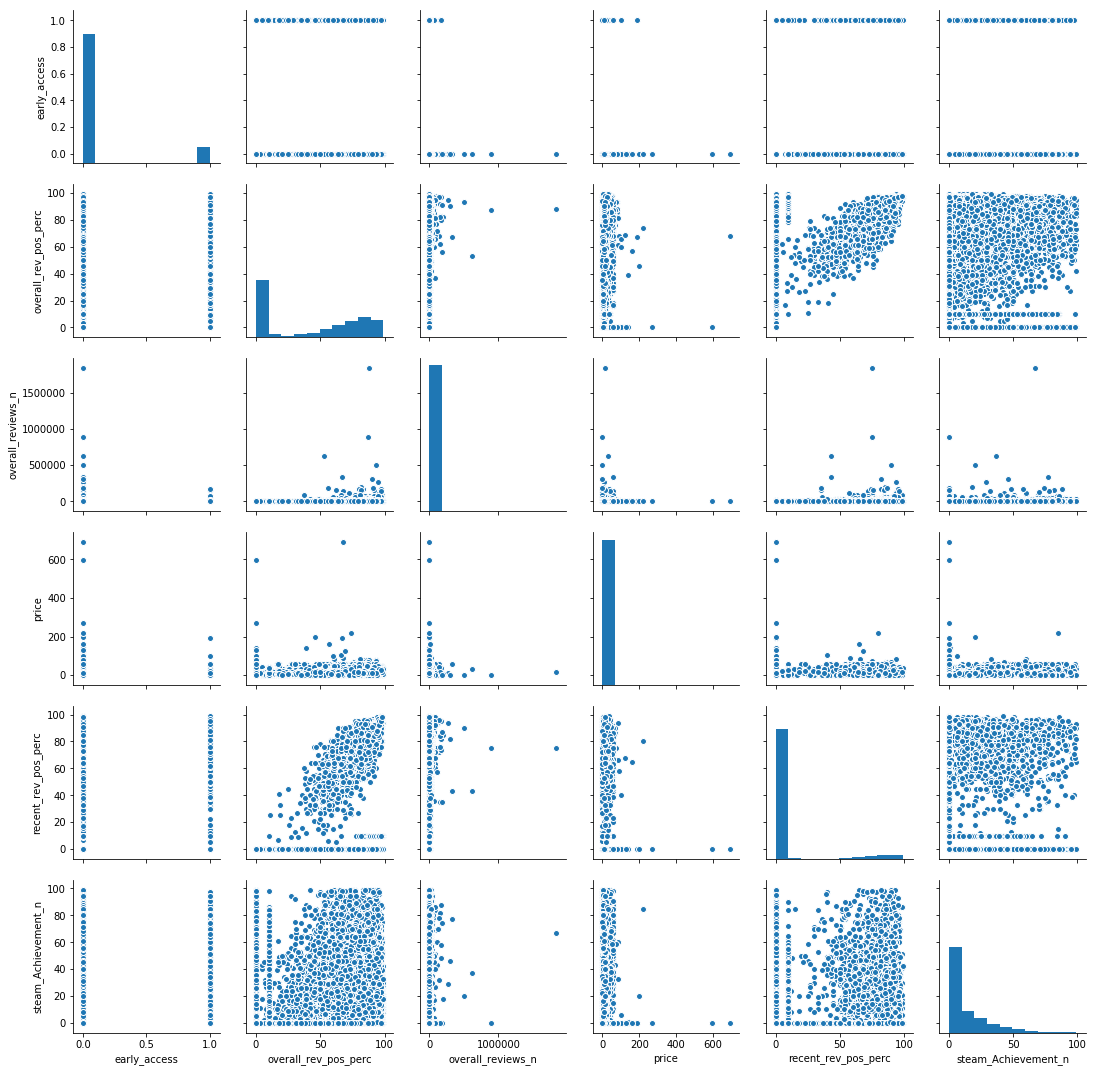

In [12]:
sns.pairplot(steam_games_df);

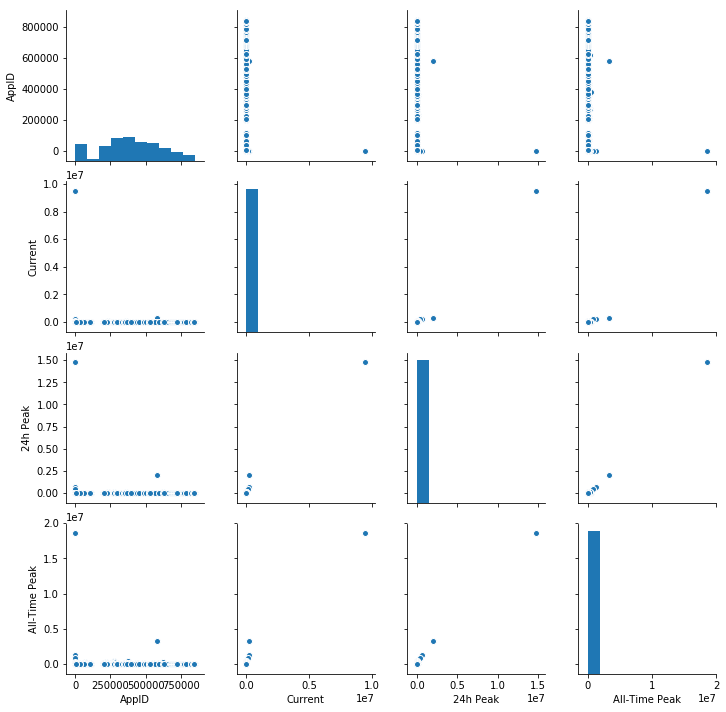

In [41]:
sns.pairplot(steamDB_users_df);

In [61]:
steamDB_users_df['AppID'] = steamDB_users_df['AppID'].astype('int64')
steamDB_users_df['AppID'].dtype

In [67]:
# combine the tables:
steam_combined = pd.merge(steam_games_df, steamDB_users_df, left_on='app_name', right_on='Name', how='inner', sort=False)

In [102]:
steam_combined.rename(columns={'All-Time Peak': 'All_Time_Peak_concurrent_users', 'Release Date': 'Release_Date'}, inplace=True)

In [ ]:
steam_combined.fillna(0)

# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('All_Time_Peak_concurrent_users ~ Developer + Genre + Publisher + \
Release_Date + discount_price + early_access + esrb + mature_reasons + \
metascore + overall_rev_pos_perc + overall_reviews_n + price + \
recent_rev_pos_perc + recent_reviews_n + reviews_url + specs + \
steam_Achievement_n + tags', data=steam_combined, return_type="dataframe")

# Create your model
model = sm.OLS(y,X)
# Fit your model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

When we run this we get an error from patsy saying that not all entries are hashable.

We need to deal with the lists including the 'tags' column.

In [ ]:
steam_combined.fillna(0)

# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('All_Time_Peak_concurrent_users ~ \
overall_reviews_n + price + overall_rev_pos_perc + tags.astype(str)'\
                       , data=steam_combined, return_type="dataframe")

# Create your model
model = sm.OLS(y,X)
# Fit your model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

When we run this we get an R-squared of 1.00.

This is because the tag strings from each title is effectively uniquely identifying.

In [92]:
steam_combined.info() 
#steam_combined.esrb.astype(str).fillna(0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6478 entries, 0 to 6477
Data columns (total 27 columns):
Developer               6478 non-null object
Genre                   6478 non-null object
Publisher               6478 non-null object
Release Date            6478 non-null object
Title                   6478 non-null object
app_id                  6478 non-null object
app_name                6478 non-null object
discount_price          6478 non-null object
early_access            6478 non-null bool
esrb                    6478 non-null object
mature_reasons          6478 non-null object
metascore               6478 non-null object
overall_rev_pos_perc    6478 non-null int64
overall_reviews_n       6478 non-null int64
price                   6478 non-null float64
recent_rev_pos_perc     6478 non-null int64
recent_reviews_n        6478 non-null object
reviews_url             6478 non-null object
specs                   6478 non-null object
steam_Achievement_n     6478 non-null int6

In [94]:
steam_combined.esrb.isnull().sum()

0

In [107]:
steam_combined.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6478 entries, 0 to 6477
Data columns (total 27 columns):
Developer                         6478 non-null object
Genre                             6478 non-null object
Publisher                         6478 non-null object
Release_Date                      6478 non-null object
Title                             6478 non-null object
app_id                            6478 non-null object
app_name                          6478 non-null object
discount_price                    6478 non-null float64
early_access                      6478 non-null bool
esrb                              6478 non-null object
mature_reasons                    6478 non-null object
metascore                         6478 non-null object
overall_rev_pos_perc              6478 non-null int64
overall_reviews_n                 6478 non-null int64
price                             6478 non-null float64
recent_rev_pos_perc               6478 non-null int64
recent_reviews_n

In [108]:
steam_combined.metascore.unique()

array([0, 69, 67, 80, 74, 'NA', 84, 68, 66, 77, 60, 79, 72, 71, 73, 54,
       75, 65, 81, 82, 64, 70, 78, 45, 57, 83, 55, 63, 52, 76, 85, 62, 59,
       47, 49, 58, 86, 87, 90, 46, 94, 88, 96, 89, 56, 41, 61, 91, 92, 20,
       93, 44, 51, 53, 37, 43, 50, 38, 40, 35, 48, 39, 95, 34, 33],
      dtype=object)

In [115]:
steam_combined.metascore = steam_combined.metascore.replace('NA','NaN').astype('float')

In [99]:
steam_combined.head()

,Developer,Genre,Publisher,Release Date,Title,app_id,app_name,discount_price,early_access,esrb,...,reviews_url,specs,steam_Achievement_n,tags,url,AppID,Name,Current,24h Peak,All-Time Peak
0,[WTFOMGames],"[Action, Adventure, Casual, Indie]",[WTFOMGames],"Mar 1, 2016",! That Bastard Is Trying To Steal Our Gold !,449940,! That Bastard Is Trying To Steal Our Gold !,3.99,False,nr,...,http://steamcommunity.com/app/449940/reviews/?...,"[Single-player, Steam Trading Cards, Partial C...",0,"[Action, Indie, Casual, Adventure, Memes, Psyc...",https://store.steampowered.com/app/449940/_Tha...,449940,! That Bastard Is Trying To Steal Our Gold !,1,27,1951
1,[Paleno Games],"[Casual, Indie]",[Paleno Games],"May 5, 2017",#monstercakes,614910,#monstercakes,0.99,False,nr,...,http://steamcommunity.com/app/614910/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",18,"[Casual, Indie, Puzzle, Match 3]",https://store.steampowered.com/app/614910/mons...,614910,#monstercakes,57,70,189
2,[Eko],"[Adventure, Indie]",[Eko],"Mar 14, 2018",#WarGames,779420,#WarGames,2.99,False,nr,...,http://steamcommunity.com/app/779420/reviews/?...,"[Single-player, Steam Achievements, Full contr...",55,"[Adventure, Indie, FMV]",https://store.steampowered.com/app/779420/WarG...,779420,#WarGames,2,5,36
3,[BeHappy Studios],"[Action, Casual, Indie]",[Back To Basics Gaming],"Jul 28, 2016",$1 Ride,508290,$1 Ride,0.98,False,nr,...,http://steamcommunity.com/app/508290/reviews/?...,"[Single-player, Steam Trading Cards]",0,"[Casual, Indie, Action]",https://store.steampowered.com/app/508290/1_Ride/,508290,$1 Ride,1,4,2002
4,[Arcane Raise],"[Adventure, Casual, Indie, RPG, Strategy]",[ArcaneRaise],"May 2, 2017",- Arcane preRaise -,603780,- Arcane preRaise -,2.99,False,nr,...,http://steamcommunity.com/app/603780/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",36,"[RPG, Casual, Adventure, Indie, Strategy, Fant...",https://store.steampowered.com/app/603780/_Arc...,603780,- Arcane preRaise -,34,76,3016


In [128]:
steam_combined.fillna(0)

# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('All_Time_Peak_concurrent_users ~ \
overall_reviews_n + price + overall_rev_pos_perc + discount_price + early_access + esrb + metascore'\
                       , data=steam_combined, return_type="dataframe")

# figure out how to deal with the variables that are lists, otherwise effectively every title gets a unique variable:
# tags.astype(str)

# Create your model
model = sm.OLS(y,X)
# Fit your model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     All_Time_Peak_concurrent_users   R-squared:                       0.377
Model:                                        OLS   Adj. R-squared:                  0.376
Method:                             Least Squares   F-statistic:                     354.7
Date:                            Tue, 24 Apr 2018   Prob (F-statistic):               0.00
Time:                                    21:23:04   Log-Likelihood:                -77030.
No. Observations:                            6454   AIC:                         1.541e+05
Df Residuals:                                6442   BIC:                         1.542e+05
Df Model:                                      11                                         
Covariance Type:                        nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1704.9610   1.66e+04      0.103      0.918   -3.07e+04    3.42e+04
early_access[T.True]  -559.0148   1645.771     -0.340      0.734   -3785.272    2667.242
esrb[T.e]             -134.3428   1.66e+04     -0.008      0.994   -3.27e+04    3.24e+04
esrb[T.m]             1276.6759   1.66e+04      0.077      0.939   -3.13e+04    3.39e+04
esrb[T.nr]              60.6402   1.65e+04      0.004      0.997   -3.24e+04    3.25e+04
esrb[T.r]             2615.2252   1.81e+04      0.145      0.885   -3.28e+04     3.8e+04
esrb[T.t]             4641.9969   1.66e+04      0.280      0.780   -2.79e+04    3.72e+04
overall_reviews_n        0.9711      0.016     61.563      0.000       0.940       1.002
price                   -7.2259    174.066     -0.042      0.967    -348.454     334.002
overall_rev_pos_perc   -42.9889     18.244     -2.356      0.018     -78.753      -7.225
discount_price          89.4572    175.799      0.509      0.611    -255.167     434.082
metascore               24.5742     15.863      1.549      0.121      -6.522      55.670
==============================================================================
Omnibus:                    21069.868   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       4608422136.414
Skew:                          54.706   Prob(JB):                         0.00
Kurtosis:                    4141.239   Cond. No.                     2.60e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.6e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Combining and streamlining all of the data cleaning and applying it to the steam_combined_fuzzy df (in addition to the original steam_combined df):

In [198]:
from sklearn.feature_extraction.text import CountVectorizer as cv

In [207]:
vect = cv()
vect.fit(steam_combined.tags.str.join(' '))
X = vect.transform(steam_combined.tags.str.join(' '))
df2 = pd.DataFrame(X.toarray(),columns=vect.get_feature_names())
steam_combined_expanded = steam_combined.join(df2)

In [208]:
steam_combined_expanded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6478 entries, 0 to 6477
Columns: 407 entries, Developer to zombies
dtypes: bool(1), float64(3), int64(388), object(15)
memory usage: 20.4+ MB


In [209]:
steam_combined_expanded.head()

,Developer,Genre,Publisher,Release_Date,Title,app_id,app_name,discount_price,early_access,esrb,...,web,werewolves,western,with,word,workshop,world,wrestling,your,zombies
0,[WTFOMGames],"[Action, Adventure, Casual, Indie]",[WTFOMGames],"Mar 1, 2016",! That Bastard Is Trying To Steal Our Gold !,449940,! That Bastard Is Trying To Steal Our Gold !,3.99,False,nr,...,0,0,0,0,0,0,0,0,0,0
1,[Paleno Games],"[Casual, Indie]",[Paleno Games],"May 5, 2017",#monstercakes,614910,#monstercakes,0.99,False,nr,...,0,0,0,0,0,0,0,0,0,0
2,[Eko],"[Adventure, Indie]",[Eko],"Mar 14, 2018",#WarGames,779420,#WarGames,2.99,False,nr,...,0,0,0,0,0,0,0,0,0,0
3,[BeHappy Studios],"[Action, Casual, Indie]",[Back To Basics Gaming],"Jul 28, 2016",$1 Ride,508290,$1 Ride,0.98,False,nr,...,0,0,0,0,0,0,0,0,0,0
4,[Arcane Raise],"[Adventure, Casual, Indie, RPG, Strategy]",[ArcaneRaise],"May 2, 2017",- Arcane preRaise -,603780,- Arcane preRaise -,2.99,False,nr,...,0,0,0,0,0,0,0,0,0,0


Let's turn this into a function now that it's working:

In [390]:
def create_new_columns_as_counts_from_lists(old_df, colname):
    vect = cv()
    vect.fit(old_df[colname].str.join(' '))
    X = vect.transform(old_df[colname].str.join(' '))
    df_of_new_cols = pd.DataFrame(X.toarray(),columns=vect.get_feature_names())
    new_df = old_df.join(df_of_new_cols, rsuffix=colname).copy()
    return new_df
    """Function takes an old dataframe and makes a new dataframe expanding a column with lists into several columns with counts for each element in the set of values in the lists.

    Args:
        old_df: The original dataframe.
        colname: The name of the column containing the lists.

    Returns:
        New dataframe with additional columns with counts for the elements in the lists in the original column

    """

In [378]:
steam_combined_expanded = create_new_columns_as_counts_from_lists(steam_combined,'tags')

In [361]:
steam_combined_expanded.reset_index().head()

,level_0,index,Developer,Genre,Publisher,Release_Date,Title,app_id,app_name,discount_price,...,web,werewolves,western,with,word,workshop,world,wrestling,your,zombies
0,0,0,[WTFOMGames],"[Action, Adventure, Casual, Indie]",[WTFOMGames],"Mar 1, 2016",! That Bastard Is Trying To Steal Our Gold !,449940,! That Bastard Is Trying To Steal Our Gold !,3.99,...,0,0,0,0,0,0,0,0,0,0
1,1,1,[Paleno Games],"[Casual, Indie]",[Paleno Games],"May 5, 2017",#monstercakes,614910,#monstercakes,0.99,...,0,0,0,0,0,0,0,0,0,0
2,2,2,[Eko],"[Adventure, Indie]",[Eko],"Mar 14, 2018",#WarGames,779420,#WarGames,2.99,...,0,0,0,0,0,0,0,0,0,0
3,3,3,[BeHappy Studios],"[Action, Casual, Indie]",[Back To Basics Gaming],"Jul 28, 2016",$1 Ride,508290,$1 Ride,0.98,...,0,0,0,0,0,0,0,0,0,0
4,4,4,[Arcane Raise],"[Adventure, Casual, Indie, RPG, Strategy]",[ArcaneRaise],"May 2, 2017",- Arcane preRaise -,603780,- Arcane preRaise -,2.99,...,0,0,0,0,0,0,0,0,0,0


In [368]:
set(steam_combined.columns)&set(df_of_new_cols.columns)

set()

In [ ]:
for i in steam_combined_expanded.columns:
    print(i)

In [338]:
def not_list_to_empty_list(row):
    if type(row) != list:
        row = []
    return row

In [379]:
steam_combined_expanded['Genre_new'] = steam_combined_expanded.Genre.apply(not_list_to_empty_list)

Checking to make sure that this worked well:

In [380]:
#for elem in steam_combined_expanded.Genre_new:
#    print(type(elem))

typelist = []
for x in steam_combined_expanded['Genre_new']:
    typelist.append(type(x))

print(int in typelist)

False


In [381]:
steam_combined_expanded = create_new_columns_as_counts_from_lists(steam_combined_expanded,'Genre_new')

Let's start fresh with our new functions:

In [406]:
def not_list_to_empty_list(row):
    if type(row) != list:
        row = []
    return row

In [416]:
def create_new_columns_as_counts_from_lists(old_df, colname):
    vect = cv()
    vect.fit(old_df[colname].str.join(' '))
    X = vect.transform(old_df[colname].str.join(' '))
    df_of_new_cols = pd.DataFrame(X.toarray(),columns=vect.get_feature_names())
    new_df = old_df.join(df_of_new_cols, rsuffix=colname).copy()
    return new_df
    """Makes a new dataframe expanding a column with lists into several columns with counts for each element"""

In [408]:
def expand_list_columns(df, colname):
    newcolname = colname+'_new'
    df[newcolname] = df[colname].apply(not_list_to_empty_list)
    df = create_new_columns_as_counts_from_lists(df,newcolname).copy()
    return df

In [444]:
steam_combined_expanded = expand_list_columns(steam_combined,'tags').copy()

In [445]:
steam_combined_expanded = expand_list_columns(steam_combined_expanded,'Genre').copy()

In [446]:
steam_combined_expanded = expand_list_columns(steam_combined_expanded,'Developer').copy()

In [447]:
steam_combined_expanded = expand_list_columns(steam_combined_expanded,'Publisher').copy()

In [448]:
steam_combined_expanded = expand_list_columns(steam_combined_expanded,'specs').copy()

In [449]:
steam_combined_expanded = expand_list_columns(steam_combined_expanded,'mature_reasons').copy()

In [450]:
#steam_combined_expanded = create_new_columns_as_counts_from_lists(steam_combined_expanded,'esrb').copy()
y,X = patsy.dmatrices('All_Time_Peak_concurrent_users ~ esrb + early_access', data=steam_combined_expanded, return_type="dataframe")
#X.head()
for colname in X.columns:
    steam_combined_expanded[colname] = X[colname]

In [451]:
steam_combined_expanded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6478 entries, 0 to 6477
Columns: 9501 entries, Developer to early_access[T.True]
dtypes: bool(1), float64(10), int64(9469), object(21)
memory usage: 469.9+ MB


In [475]:
y = steam_combined_expanded['All_Time_Peak_concurrent_users']
X = steam_combined_expanded.drop(['specs','specs_new','early_access','Title' , 'tags' , 'tags_new' , 'Genre' , 'Genre_new' , 'Developer' , 'Developer_new' , 'Publisher' , 'Publisher_new' , 'mature_reasons' , 'mature_reasons_new' , 'esrb' , 'app_id' , 'app_name' , 'url' , 'reviews_url' , 'AppID' , 'Name' , 'Current' , '24h Peak', 'All_Time_Peak_concurrent_users'], axis=1)
#X['intercept']=1 #This is now taken care off by the patsy step with esrb
#X.intercept.dtype

In [443]:
X.head()

,Release_Date,discount_price,early_access,metascore,overall_rev_pos_perc,overall_reviews_n,price,recent_rev_pos_perc,recent_reviews_n,specs,...,violenceblood,violentmature_reasons_new,visit,withmature_reasons_new,Intercept,esrb[T.e],esrb[T.m],esrb[T.nr],esrb[T.r],esrb[T.t]
0,"Mar 1, 2016",3.99,False,0.0,46,15,3.99,0,0,"[Single-player, Steam Trading Cards, Partial C...",...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,0.0
1,"May 5, 2017",0.99,False,0.0,90,272,0.99,80,10,"[Single-player, Steam Achievements, Steam Trad...",...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,0.0
2,"Mar 14, 2018",2.99,False,0.0,66,54,2.99,0,0,"[Single-player, Steam Achievements, Full contr...",...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,0.0
3,"Jul 28, 2016",0.98,False,0.0,58,80,0.98,0,0,"[Single-player, Steam Trading Cards]",...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,0.0
4,"May 2, 2017",2.99,False,0.0,28,25,2.99,0,0,"[Single-player, Steam Achievements, Steam Trad...",...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,0.0


Figuring out which columns still had offending non-numerical values:

In [454]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6478 entries, 0 to 6477
Columns: 9477 entries, Release_Date to early_access[T.True]
dtypes: float64(10), int64(9465), object(2)
memory usage: 468.7+ MB


In [ ]:
X.select_dtypes(include='object')
# Release_Date and recent_reviews_n

Making appropriate dataframes for modeling by dropping inapppriate columns (X variables):

In [475]:
y = steam_combined_expanded['All_Time_Peak_concurrent_users']
X = steam_combined_expanded.drop(['Release_Date','specs','specs_new','early_access','Title' , 'tags' , 'tags_new' , 'Genre' , 'Genre_new' , 'Developer' , 'Developer_new' , 'Publisher' , 'Publisher_new' , 'mature_reasons' , 'mature_reasons_new' , 'esrb' , 'app_id' , 'app_name' , 'url' , 'reviews_url' , 'AppID' , 'Name' , 'Current' , '24h Peak', 'All_Time_Peak_concurrent_users'], axis=1)
#X['intercept']=1 #This is now taken care off by the patsy step with esrb
#X.intercept.dtype

Fixing columns with offending non-numerical values:

In [471]:
# Temporarily excluding release date
#X.Release_Date = pd.to_datetime(X.Release_Date, errors='coerce')

In [477]:
X.recent_reviews_n = X.recent_reviews_n.str.replace(',','').astype(float)

In [484]:
# Create your model
#model = sm.OLS(y,X)
model = sm.OLS(y,X.astype(float))
# Fit your model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

ValueError: On entry to DLASCL parameter number 4 had an illegal value

In [481]:
from sklearn import model_selection, pipeline, preprocessing, linear_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
import numpy as np

In [486]:
y = y.reset_index().as_matrix().astype(np.float)
X = X.reset_index().as_matrix().astype(np.float)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

notes on steps from Julia:

test-train split

score on x_train, y_train and x_test, y_test

standardize

lasso

plot residuals

seaborn jointplot for my strongest x

put my lasso-determined variables back into statsmodels

In [504]:
elastic_pipe = pipeline.Pipeline([
    ("std", preprocessing.StandardScaler()),
    ("elastic", linear_model.ElasticNet(alpha=1.0, l1_ratio=0.5))
])

In [505]:
elastic_pipe.fit(np.nan_to_num(X), y)
#linear_model.ElasticNet(alpha=1.0, l1_ratio=0.5).fit(X.astype(float), y)

Pipeline(memory=None,
     steps=[('std', StandardScaler(copy=True, with_mean=True, with_std=True)), ('elastic', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))])

In [511]:
y_pred = elastic_pipe.predict(np.nan_to_num(X))

In [512]:
sns.plot(y,X)

AttributeError: module 'seaborn' has no attribute 'plot'

In [506]:
coefs = elastic_pipe.named_steps["elastic"].coef_

In [508]:
coefs

array([[ 856.32369741,    5.61155376,    1.35147682, ...,   -2.83633939,
           1.89528958,    4.02693438],
       [ -83.30222803,  443.44070888,  725.20906803, ...,  103.6567206 ,
          78.26826457, -117.4336927 ]])

In [507]:
best_i = np.argmax(test_scores)

best_c = coefs[best_i,:]
best_c

NameError: name 'best_i' is not defined

In [ ]:
scatter(np.arange(len(best_c)), np.abs(best_c))
plt.xticks(np.arange(len(best_c)), x.columns, rotation=90);

In [503]:
#import numpy as np
#y = y.reset_index().as_matrix().astype(np.float)
#X = X.reset_index().as_matrix().astype(np.float)
preprocessing.StandardScaler().fit_transform(np.nan_to_num(X), y)

array([[-1.73178345, -0.49174893, -0.59838096, ..., -0.06348038,
        -0.31031241, -0.31418305],
       [-1.73124871, -0.70170418, -0.59838096, ..., -0.06348038,
        -0.31031241, -0.31418305],
       [-1.73071396, -0.56173401, -0.59838096, ..., -0.06348038,
        -0.31031241, -0.31418305],
       ...,
       [ 1.73071396,  0.27808699, -0.59838096, ..., -0.06348038,
         3.22255888, -0.31418305],
       [ 1.73124871,  0.27808699, -0.59838096, ..., -0.06348038,
        -0.31031241, -0.31418305],
       [ 1.73178345, -0.77098941, -0.59838096, ..., -0.06348038,
        -0.31031241, -0.31418305]])

In [501]:
np.nan_to_num(X)

array([[0.000e+00, 3.990e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.000e+00, 9.900e-01, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.000e+00, 2.990e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [6.475e+03, 1.499e+01, 0.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [6.476e+03, 1.499e+01, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [6.477e+03, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

In [ ]:
# Unpack this:

fig, axes = plt.subplots(2,1, figsize=(15, 8), sharex=True, tight_layout=True)

alphas = np.logspace(.5,5, num=50)
coefs = []
train_scores = []
test_scores = []

# fig, axes = plt.subplots(1,len(alphas), figsize=(20, 8), sharey=True)
for i, alpha in enumerate(alphas):
    lasso_pipe.set_params(lasso__alpha=alpha)
    cv_result = model_selection.cross_validate(
        lasso_pipe, X=x, y=y, cv=10, return_train_score=True)
    train_scores.append(np.maximum(np.mean(cv_result['train_score']), 0))
    test_scores.append(np.maximum(np.mean(cv_result['test_score']), 0))
    lasso_pipe.fit(x_train, y_train)
    coefs.append(lasso_pipe.named_steps["lasso"].coef_)
    

coefs = np.squeeze(coefs, axis=1)
ax0 = axes.flat[0]
ax0.plot(-alphas, 1 - np.array(train_scores), label="train")
ax0.plot(-alphas, 1 - np.maximum(test_scores, 0), label="test")
best_i = np.argmax(test_scores)
ax0.vlines(-alphas[best_i], 0,1, colors="red", linestyles="dotted")
ax0.set_ylabel("1 - $r^2$")
ax1 = axes.flat[1]
ax1.plot(-alphas,coefs)
ax1.set_ylabel("coefficient values")
ax1.set_xlabel("-alpha")
ax1.set_xscale("symlog")
plt.xscale("symlog")
# plt.yscale("symlog")

From notebooks:

In [ ]:
model = ols("line_duration ~"+ regression_formula, data=df_r).fit()
fig = plt.figure(figsize=(15,15))

# pass in the model as the first parameter, then specify the 
# predictor variable we want to analyze
fig = sm.graphics.plot_regress_exog(model, "year", fig=fig)

In [ ]:
from sklearn.model_selection import cross_validate

lasso_pipe = pipeline.Pipeline([
    ("imp", preprocessing.Imputer()), 
    ("std", preprocessing.StandardScaler()),
    ("lasso", linear_model.Lasso())
])
fig, axes = plt.subplots(2,1, figsize=(15, 8), sharex=True, tight_layout=True)

# start lower -- .1
alphas = np.logspace(-1,3, num=50)
coefs = []
train_scores = []
test_scores = []
# fig, axes = plt.subplots(1,len(alphas), figsize=(20, 8), sharey=True)
for i, alpha in enumerate(alphas):
    lasso_pipe.set_params(lasso__alpha=alpha)
    cv_result = cross_validate(lasso_pipe, X=X, y=y, cv=10, return_train_score=True)
    train_scores.append(np.maximum(np.mean(cv_result['train_score']), 0))
    test_scores.append(np.maximum(np.mean(cv_result['test_score']), 0))
    lasso_pipe.fit(X_train, y_train)
    coefs.append(lasso_pipe.named_steps["lasso"].coef_)
    

coefs = np.squeeze(coefs, axis=1)
ax0 = axes.flat[0]
ax0.plot(-alphas, 1 - np.array(train_scores), label="train")
ax0.plot(-alphas, 1 - np.maximum(test_scores, 0), label="test")
best_i = np.argmax(test_scores)
ax0.vlines(-alphas[best_i], 0,1, colors="red", linestyles="dotted")
ax0.set_ylabel("1 - $r^2$")
ax1 = axes.flat[1]
ax1.plot(-alphas,coefs)
ax1.set_ylabel("coefficient values")
ax1.set_xlabel("-alpha")
ax1.set_xscale("symlog")
plt.xscale("symlog")
# plt.yscale("symlog")

In [ ]:
#getting X and Y
X = df_r.loc[:, df_r.columns != 'line_duration']
# Choose response variable(s)
y = df_r['line_duration']

In [ ]:
# same as above, just using more straightforward OLS method from statsmodels
model = sm.OLS(y,X)
results = model.fit()
results.summary()
#fig = sm.graphics.plot_regress_exog(results, "year", fig=fig)

Testing writing to output file for cleaner notebooks:

In [1]:
import pickle

In [555]:
#picklelist = [y, X, steamDB_users_df_fuzzy_final, steamDB_users_df_fuzzy, steamDB_users_df, steam_combined, steam_combined_expanded, steam_combined_fuzzy]

# Saving the objects:

#with open('objs_steam_data.pkl', 'wb') as f:
#    pickle.dump(picklelist, f)
#f.close()

In [2]:
# Getting back the objects:
with open('objs_steam_data.pkl', 'rb') as f:
    y, X, steamDB_users_df_fuzzy_final, steamDB_users_df_fuzzy, steamDB_users_df, steam_combined, steam_combined_expanded, steam_combined_fuzzy = pickle.load(f)
f.close()

array([[0.000e+00, 3.990e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.000e+00, 9.900e-01, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.000e+00, 2.990e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [6.475e+03, 1.499e+01, 0.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [6.476e+03, 1.499e+01, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [6.477e+03, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

In [ ]:
f = open("fuzzy_match_output.txt","w+")
f.close()
match_names=[]
scores=[]

for name in steamDB_users_df['Name']:
    if name in missing_names:
        match_name, score = process.extractOne(name, list(steam_games_df['app_name']))
    else:
        match_name = name
        score = 100
    match_names.append(match_name)
    scores.append(score)
    print(name, '~', match_name, ' : ', score)
    print(name, '~', match_name, ' : ', score, file=open('fuzzy_match_output.txt', 'a'))

steamDB_users_df_fuzzy['steam_match_name'] = match_names
steamDB_users_df_fuzzy['fuzzy_score'] = scores

In [559]:
# Testing output writing to file:

f = open("output_test.txt","w+")
f.close()

for i in range(0,11):
    print(i, '~', 2*i)
    print(i, '~', 2*i, file=open('output_test.txt', 'a'))

0 ~ 0
1 ~ 2
2 ~ 4
3 ~ 6
4 ~ 8
5 ~ 10
6 ~ 12
7 ~ 14
8 ~ 16
9 ~ 18
10 ~ 20


In [539]:
for name in steamDB_users_df['Name']:
    if name not in missing_names:
        steamDB_users_df_fuzzy['steam_match_name'] = name
        steamDB_users_df_fuzzy['fuzzy_score'] = 100

Debugging:

In [311]:
# steam_combined_expanded.Genre.dtype

#steam_combined_expanded.Genre.isnull().unique() # no nulls
#steam_combined_expanded.Genre
#steam_combined_expanded.Genre.fillna(' ')
#steam_combined_expanded.Genre.unique()
#steam_combined_expanded.loc[steam_combined_expanded['Genre'] == ' ']

#steam_combined_expanded2 = create_new_columns_as_counts_from_lists(steam_combined_expanded,'Genre')

#def not_list_to_empty_list():
#    for elem in elems:
#        if type(elem) != 'list':
#            return list([])


In [435]:
#for x in X.columns:
#    print(x+' is '+str(type(x)))

X.discount_price = X.discount_price.apply(pd.to_numeric)

Other attempts at dealing with the lists of tags and genres:

Using OneHotEncoder:

In [ ]:
from sklearn.preprocessing import OneHotEncoder
oh = OneHotEncoder()
oh.fit(steam_combined.tags)

Manually, by building a set from the lists:

In [130]:
sum_tag_set = set()
for tag_list in steam_combined.tags:
    sum_tag_set.update(tag_list)

In [ ]:
sum_tag_set

In [182]:
steam_combined_expanded = steam_combined.copy()

In [183]:
# make a set of all tags that exist for all titles:
sum_tag_set = set()
for tag_list in steam_combined.tags:
    sum_tag_set.update(tag_list)

In [184]:
# create a column of False booleans for each tag
# creating column names that have problematic characters replaced
for tag in sum_tag_set:
    steam_combined_expanded[tag.replace(' ','_').replace('\'','').replace('.','_')] = False

In [185]:
steam_combined_expanded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6478 entries, 0 to 6477
Columns: 363 entries, Developer to Dark
dtypes: bool(337), float64(3), int64(8), object(15)
memory usage: 3.4+ MB


In [186]:
# for each tag, check if the game has this tag and if it does, update the False to True:
for tag in sum_tag_set:
    if tag in steam_combined_expanded['tags']:
        steam_combined_expanded[tag.replace(' ','_').replace('\'','').replace('.','_')] = True

In [187]:
sum_renamed_tag_set = {tag.replace(' ','_').replace('\'','').replace('.','_') for tag in sum_tag_set}
patsy_tag_string = ' + '.join(sum_renamed_tag_set)
print(patsy_tag_string)

Football + Bullet_Time + Management + Voxel + Strategy + Horror + Casual + Demons + Nudity + Gambling + Tutorial + Word_Game + VR + Naval + Rome + Real-Time + Soundtrack + Golf + Sokoban + Atmospheric + Music + Logic + Documentary + Cartoony + On-Rails_Shooter + Character_Action_Game + Turn-Based + Design_&_Illustration + World_War_II + Cycling + Movie + 2_5D + 6DOF + Massively_Multiplayer + Aliens + Werewolves + 3D_Platformer + God_Game + Board_Game + Top-Down + Hack_and_Slash + Lemmings + First-Person + Parkour + Comic_Book + Building + Rhythm + Warhammer_40K + Cult_Classic + Benchmark + Comedy + Cartoon + Robots + Remake + LEGO + Score_Attack + America + Third-Person_Shooter + Utilities + Side_Scroller + Funny + Noir + Modern + Conversation + Multiplayer + Blood + Education + Assassin + Open_World + Realistic + Stealth + Real_Time_Tactics + Racing + Fantasy + Touch-Friendly + Isometric + Sci-fi + Wargame + Turn-Based_Tactics + Trading_Card_Game + FMV + Swordplay + CRPG + Chess + For

In [192]:
steam_combined_expanded.Zombies.unique()

array([False])

In [ ]:
patsy_variable_list = list(steam_combined_expanded.columns)
#patsy_variable_list.remove('Developer')
patsy_variable_list_remove = \
[\
    'Title' , \
    'app_id' , \
    'app_name' , \
    'tags' , \
    'url' , \
    'reviews_url' , \
    'AppID' , \
    'Name' , \
    'Current' , \
    '24h Peak', \
    'All_Time_Peak_concurrent_users'\
]
# don't need patsy for the columns that we vectorized

patsy_variable_list = [x for x in patsy_variable_list if x not in patsy_variable_list_remove]

patsy_variable_string = (' + ').join(patsy_variable_list)
#patsy_variable_string

In [526]:
# Fuzzywuzzy examples

#choices = ["Atlanta Falcons", "New York Jets", "New York Giants", "Dallas Cowboys"]
#process.extract("new york jets", choices, limit=2)
#process.extractOne("cowboys", choices)


[('New York Jets', 100), ('New York Giants', 79)]